# Problem Statement

here

In [33]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)

import plotly.express as px
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR, LinearSVR

import lightgbm as lgb


df = pd.read_csv("./data/year_2016_clean.csv", sep=";")
df.head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,ComplianceStatus,Outlier,ZipCode,Latitude,Longitude,NbProperty,BuildingAge
0,1,NonResidential,hotel_catering -,7,downtown,1,12,88434,0.0,88434.0,hotel_catering -,hotel_catering -,88434.0,none,0.0,none,0.0,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,249.98,2.83,Compliant,NaN,98101,47.61220,-122.33799,1,89
1,2,NonResidential,hotel_catering -,7,downtown,1,11,103566,15064.0,88502.0,hotel_catering -,hotel_catering -,83880.0,none,15064.0,hotel_catering -,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,295.86,2.86,Compliant,NaN,98101,47.61317,-122.33393,3,20
2,3,NonResidential,hotel_catering -,7,downtown,1,41,956110,196718.0,759392.0,hotel_catering -,hotel_catering -,756493.0,none,0.0,none,0.0,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,2089.28,2.19,Compliant,NaN,98101,47.61393,-122.33810,1,47
3,5,NonResidential,hotel_catering -,7,downtown,1,10,61320,0.0,61320.0,hotel_catering -,hotel_catering -,61320.0,none,0.0,none,0.0,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,286.43,4.67,Compliant,NaN,98101,47.61412,-122.33664,1,90
4,8,NonResidential,hotel_catering -,7,downtown,1,18,175580,62000.0,113580.0,hotel_catering - leisure -,hotel_catering -,123445.0,none,68009.0,leisure -,0.0,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,505.01,2.88,Compliant,NaN,98121,47.61375,-122.34047,3,36


---

# Feature Engineering

In [3]:
df["RateParking"] = round(df.PropertyGFAParking / df.PropertyGFATotal, 4)
df["RateBuilding"] = round(df['PropertyGFABuilding(s)'] / df.PropertyGFATotal, 4)
df["RatePerFloors"] = round(df.PropertyGFATotal / df.NumberofFloors, 4)
df["RatePerBuildings"] = round(df.PropertyGFATotal / df.NumberofBuildings, 4)
df["RateLargestPropertyUseType"] = round(df.LargestPropertyUseTypeGFA / df.PropertyGFATotal, 4)
df["RateSecondLargestPropertyUseType"] = round(df.SecondLargestPropertyUseTypeGFA / df.PropertyGFATotal, 4)
df["RateThirstLargestPropertyUseType"] = round(df.ThirdLargestPropertyUseTypeGFA / df.PropertyGFATotal, 4)
df["NumberOfAllUseTypes"] = df.ListOfAllPropertyUseTypes.str.count(" - ") + 1

useless 'CouncilDistrictCode', 'ListOfAllPropertyUseTypes', 'ENERGYSTARScore'

target 'TotalGHGEmissions'  
supprimer 'GHGEmissionsIntensity'

In [4]:
data = df.drop(columns=['CouncilDistrictCode', 'ListOfAllPropertyUseTypes', 'ENERGYSTARScore', 'GHGEmissionsIntensity', 'Outlier'])

In [5]:
data.shape

(3353, 41)

In [6]:
X = data.drop(columns = ['TotalGHGEmissions'])
y = data[['TotalGHGEmissions']]

In [7]:
X.isnull().sum().sum()

0

shuffle + dummy regressor

In [8]:
# general seed for sk learn
np.random.seed(42)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [10]:
num_cols = X.select_dtypes(include='number').columns
robust_scaler = RobustScaler()

X_train_num_sc = pd.DataFrame(
    robust_scaler.fit_transform(X_train[num_cols]),
    columns=num_cols,
    index=X_train.index
)

In [11]:
X_test_num_sc = pd.DataFrame(
    robust_scaler.transform(X_test[num_cols]),
    columns=num_cols,
    index=X_test.index
)

In [12]:
X_train_num_sc.shape, X_test_num_sc.shape

((2682, 33), (671, 33))

In [13]:
X_train_num_sc.isnull().sum().sum(), X_test_num_sc.isnull().sum().sum()

(0, 0)

In [14]:
# df.isin([np.inf, -np.inf]).sum()


cat_cols = X_train.select_dtypes(exclude='number').columns

ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')

X_train_cat_enc = ohe.fit_transform(X_train[cat_cols])
X_train_cat_enc = pd.DataFrame(
    X_train_cat_enc,
    columns=ohe.get_feature_names_out(X_train.select_dtypes(exclude='number').columns),
    index=X_train.index
)

X_test_cat_enc = ohe.transform(X_test[cat_cols])
X_test_cat_enc = pd.DataFrame(
    X_test_cat_enc,
    columns=ohe.get_feature_names_out(X_test.select_dtypes(exclude='number').columns),
    index=X_test.index
)

C:\Users\obrunet\Anaconda3\envs\nrj\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [3, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [15]:
X_train_cat_enc.shape, X_test_cat_enc.shape

((2682, 81), (671, 81))

In [16]:
X_train_cat_enc.isnull().sum().sum(), X_test_cat_enc.isnull().sum().sum()

(0, 0)

In [17]:
X_train_enc = pd.concat([X_train_num_sc, X_train_cat_enc], axis=1)
X_test_enc = pd.concat([X_test_num_sc, X_test_cat_enc], axis=1)

In [18]:
X_train_enc.shape, X_test_enc.shape

((2682, 114), (671, 114))

In [19]:
X_train_enc.isnull().sum().sum(), X_test_enc.isnull().sum().sum()

(0, 0)

In [20]:
X_test_enc[[col for col in X_test_enc.columns if X_test_enc[col].hasnans]].isnull().sum()

Series([], dtype: float64)

In [22]:
def regression(model, name, X, y):
    metrics = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
    score = cross_validate(model, X, y , cv=5, scoring=metrics, return_train_score=True)
    
    dic = {
        'model ': [name],
        'train r²': [score['train_r2'].mean()],
        'test r²': [score['test_r2'].mean()],
        'train RMSE': [np.sqrt(- (score['train_neg_mean_squared_error'].mean()))],
        'test RMSE': [np.sqrt(- (score['test_neg_mean_squared_error'].mean()))],
        'train MAE': [np.sqrt(- (score['train_neg_mean_absolute_error'].mean()))],
        'test MAE': [np.sqrt(- (score['test_neg_mean_absolute_error'].mean()))],
    }
    return pd.DataFrame(dic)

In [23]:
def compare_results(X, y):
    results = pd.DataFrame()
    model = []
    model.append(('dummy_regressor', DummyRegressor()))
    model.append(('svr', SVR()))
    model.append(('decision_tree', DecisionTreeRegressor()))
    model.append(('random_forest', RandomForestRegressor()))
    model.append(('adaBoost', AdaBoostRegressor()))
    model.append(('lgbm', lgb.LGBMRegressor()))
    
    for name, mod in model:
        res = regression(mod, name, X, y)
        results = pd.concat([results, res], ignore_index=True)
    return results.style.hide_index()

In [24]:
compare_results(X_train_enc, y_train)

C:\Users\obrunet\Anaconda3\envs\nrj\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\obrunet\Anaconda3\envs\nrj\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\obrunet\Anaconda3\envs\nrj\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\obrunet\Anaconda3\envs\nrj\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

model,train r²,test r²,train RMSE,test RMSE,train MAE,test MAE
dummy_regressor,0.000000,-0.011977,522.130882,522.457472,11.528955,11.531474
svr,-0.017553,-0.035544,526.641603,526.707679,10.058144,10.061211
decision_tree,1.000000,0.654523,0.000000,309.774264,0.000000,5.061701
random_forest,0.943723,0.800730,123.320499,280.135849,2.774561,4.422626
adaBoost,0.874996,0.370977,163.963731,458.058619,10.801661,11.674612
lgbm,0.759340,0.211174,255.255250,409.587614,5.362690,6.873892


In [26]:
model_list = [
    DummyRegressor(),
    SVR(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    AdaBoostRegressor(),
    lgb.LGBMRegressor(),
    GradientBoostingRegressor(),
    ExtraTreesRegressor()
]

In [27]:
X_test_enc.isnull().sum().sum()

0

In [28]:
model_names = [str(m)[:str(m).index('(')] for m in model_list]
rmse_train, rmse_test = [], []

def get_rmse(reg, model_name):
    """Print the score for the model passed in argument & return scores for the train / test sets"""
    y_train_pred, y_pred = reg.predict(X_train_enc), reg.predict(X_test_enc)
    rmse_train, rmse_test = np.sqrt(mean_squared_error(y_train, y_train_pred)), np.sqrt(mean_squared_error(y_test, y_pred))
    print(model_name, f'\t - RMSE on training = {rmse_train:.2f} / on test = {rmse_test:.2f}')
    return rmse_train, rmse_test


# fit and predict all models
for model, name in zip(model_list, model_names):
    model.fit(X_train_enc, y_train)
    sc_train, sc_test = get_rmse(model, name)
    rmse_train.append(sc_train)
    rmse_test.append(sc_test)
    

df_score = pd.DataFrame({
    'model_names': model_names,
    'rmse_train': rmse_train,
    'rmse_test': rmse_test
})

C:\Users\obrunet\Anaconda3\envs\nrj\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


DummyRegressor 	 - RMSE on training = 522.15 / on test = 605.41
SVR 	 - RMSE on training = 526.22 / on test = 611.72
DecisionTreeRegressor 	 - RMSE on training = 0.00 / on test = 218.64


C:\Users\obrunet\AppData\Local\Temp\ipykernel_17588\903984297.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_enc, y_train)


RandomForestRegressor 	 - RMSE on training = 110.44 / on test = 188.18


C:\Users\obrunet\Anaconda3\envs\nrj\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor 	 - RMSE on training = 127.57 / on test = 258.66
LGBMRegressor 	 - RMSE on training = 225.84 / on test = 227.58


C:\Users\obrunet\Anaconda3\envs\nrj\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor 	 - RMSE on training = 6.07 / on test = 172.48


C:\Users\obrunet\AppData\Local\Temp\ipykernel_17588\903984297.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_enc, y_train)


ExtraTreesRegressor 	 - RMSE on training = 0.00 / on test = 78.36


In [29]:
df_score

,model_names,rmse_train,rmse_test
0,DummyRegressor,5.221517e+02,605.411012
1,SVR,5.262221e+02,611.716741
2,DecisionTreeRegressor,6.806300e-17,218.644352
3,RandomForestRegressor,1.104450e+02,188.175091
4,AdaBoostRegressor,1.275749e+02,258.662963
5,LGBMRegressor,2.258408e+02,227.580672
6,GradientBoostingRegressor,6.066924e+00,172.476845
7,ExtraTreesRegressor,7.430878e-13,78.364148


In [30]:
df_score_melt = pd.melt(df_score, id_vars=['model_names'], value_vars=['rmse_train', 'rmse_test'])

In [31]:
df_score_melt

,model_names,variable,value
0,DummyRegressor,rmse_train,5.221517e+02
1,SVR,rmse_train,5.262221e+02
2,DecisionTreeRegressor,rmse_train,6.806300e-17
3,RandomForestRegressor,rmse_train,1.104450e+02
4,AdaBoostRegressor,rmse_train,1.275749e+02
5,LGBMRegressor,rmse_train,2.258408e+02
6,GradientBoostingRegressor,rmse_train,6.066924e+00
7,ExtraTreesRegressor,rmse_train,7.430878e-13
8,DummyRegressor,rmse_test,6.054110e+02
9,SVR,rmse_test,6.117167e+02


<AxesSubplot: xlabel='value', ylabel='model_names'>

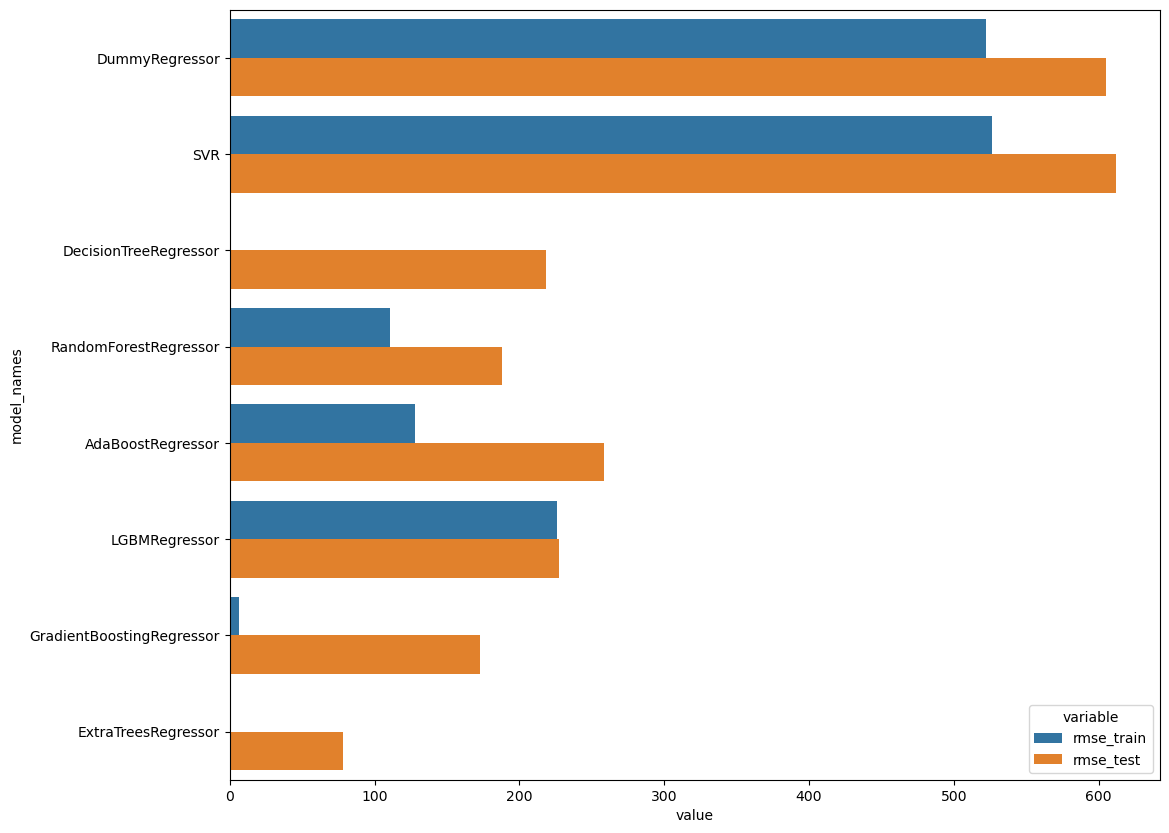

In [34]:
plt.figure(figsize=(12, 10))
sns.barplot(y="model_names", x="value", hue="variable", data=df_score_melt)

In [38]:
px.histogram(
    df_score_melt,
    x="model_names",
    y="value",
    color='variable',
    barmode='group',
    width=800,
    height=500
).show()